# Get all path to folder 

In [5]:
import glob 
import os
from tqdm import tqdm

In [3]:
root_data_path = '/mnt/storage/huyekgis/brios/datasets/Data4BRIOS'
list_area_path = os.listdir(root_data_path)

In [4]:
list_area_path

['GiaiXuan-TanKy-NgheAn',
 'HiepHoa-KinhMon-HaiDuong',
 'HoangKhai-YenSon-TuyenQuang',
 'HoaTan-KrongBong-DakLak',
 'KienBinh-KienLuong-KienGiang',
 'MuongThan-ThanUyen-LaiChau',
 'NamThai-NamTruc-NamDinh',
 'PhuocHau-NinhPhuoc-NinhThuan',
 'SonThanh-NhoQuan-NinhBinh',
 'TamHiep-ChauThanh-TienGiang']

In [109]:
list_folder_ndvi = []
list_folder_rvi = []

for area in tqdm(list_area_path):
    if area == 'HiepHoa-KinhMon-HaiDuong':
        continue
    list_folder_ndvi.append(glob.glob(f'{os.path.join(root_data_path, area)}/*_ndvi8days'))
    list_folder_rvi.append(glob.glob(f'{os.path.join(root_data_path, area)}/*_rvi_8day*'))

100%|██████████| 10/10 [00:00<00:00, 10667.10it/s]


In [110]:
list_folder_ndvi

[['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/GiaiXuan-TanKy-NgheAn/giaixuan_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/HoangKhai-YenSon-TuyenQuang/hoangkhai_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/HoaTan-KrongBong-DakLak/hoatan_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/KienBinh-KienLuong-KienGiang/kienbinh_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/MuongThan-ThanUyen-LaiChau/muongthan_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/NamThai-NamTruc-NamDinh/namthai_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/PhuocHau-NinhPhuoc-NinhThuan/phuochau_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/SonThanh-NhoQuan-NinhBinh/sonthanh_ndvi8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/TamHiep-ChauThanh-TienGiang/tamhiep_ndvi8days']]

In [111]:
list_folder_rvi

[['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/GiaiXuan-TanKy-NgheAn/giaixuan_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/HoangKhai-YenSon-TuyenQuang/hoangkhai_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/HoaTan-KrongBong-DakLak/hoatan_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/KienBinh-KienLuong-KienGiang/kienbinh_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/MuongThan-ThanUyen-LaiChau/muongthan_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/NamThai-NamTruc-NamDinh/namthai_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/PhuocHau-NinhPhuoc-NinhThuan/phuochau_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/SonThanh-NhoQuan-NinhBinh/sonthanh_rvi_8days'],
 ['/mnt/storage/huyekgis/brios/datasets/Data4BRIOS/TamHiep-ChauThanh-TienGiang/tamhiep_rvi_8days']]

# Start

In [32]:
import os
import rasterio
import numpy as np
from datetime import datetime, timedelta
import re

In [39]:
# Hàm sinh ngày cách nhau 8 ngày
def generate_dates(start_date, end_date, interval_days):
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += timedelta(days=interval_days)
    return dates

# Hàm trích xuất ngày từ tên file
def extract_date(filepath):
    match = re.search(r"\d{4}-\d{2}-\d{2}", filepath)
    if match:
        return datetime.strptime(match.group(), '%Y-%m-%d')
    return None

# Khởi tạo ngày bắt đầu và ngày kết thúc
start_date = datetime(2022, 10, 1)
end_date = datetime(2023, 10, 1)
interval_days = 8

def get_missing_date_list(directory):
    # Tạo danh sách các ngày cần có
    expected_dates = generate_dates(start_date, end_date, interval_days)

    # Lấy danh sách các ngày thực tế có trong thư mục
    actual_dates = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        date = extract_date(filepath)
        if date:
            actual_dates.append(date)

    # Tìm các ngày bị thiếu
    missing_dates = [date.strftime('%Y-%m-%d') for date in expected_dates if date not in actual_dates]
    
    return missing_dates

In [83]:
def to_timeseries_ndvi_image(folder_path):
    # Folder path containing .tif files
    folder_name = folder_path.split('/')[-1]
    # Dates with no data
    missing_dates = get_missing_date_list(folder_path)
    missing_dates = set(missing_dates)  # Convert to set for quick lookups

    # List of all available dates
    available_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

    # Check raster dimensions from a sample file
    with rasterio.open(os.path.join(folder_path, available_files[0])) as src:
        height, width = src.shape

    # Initialize list to hold time series data
    time_series = []

    # Generate the complete list of dates, assuming an 8-day interval
    start_date = '2022-10-01'
    end_date = '2023-09-26'
    current_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        file_path = os.path.join(folder_path, f"{folder_name}_{date_str}.tif")
        
        if date_str in missing_dates or not os.path.exists(file_path):
            # Append a null array for missing dates
            null_array = np.full((height, width), np.nan)
            time_series.append(null_array)
        else:
            # Read and store data for available dates
            with rasterio.open(file_path) as src:
                time_series.append(src.read(1))  # Reads the first band

        # Increment by 8 days
        current_date += timedelta(days=8)

    # Stack along the time dimension, then transpose to (x, y, time)
    ndvi_data = np.stack(time_series, axis=0).transpose(1, 2, 0)

    # Save as .npy file
    if os.path.exists('/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/'):
        output_path = f"/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/{folder_name}.npy"
        np.save(output_path, ndvi_data)
        print(f"Data saved to {output_path}")
    else:
        os.mkdir('/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/')

    


In [84]:
def save_all_ndvi_npy(list_folder):
    print('Start Saving: ')
    for folder in tqdm(list_folder, desc=f'Save NDVI tif to npy: '):
        to_timeseries_ndvi_image(folder[0])
    print('Done!!!!')

In [85]:
save_all_ndvi_npy(list_folder_ndvi)

Start Saving: 


Save NDVI tif to npy:  11%|█         | 1/9 [00:04<00:33,  4.16s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/giaixuan_ndvi8days.npy


Save NDVI tif to npy:  22%|██▏       | 2/9 [00:04<00:15,  2.19s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/hoangkhai_ndvi8days.npy


Save NDVI tif to npy:  33%|███▎      | 3/9 [00:06<00:10,  1.76s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/hoatan_ndvi8days.npy


Save NDVI tif to npy:  44%|████▍     | 4/9 [00:17<00:27,  5.45s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/kienbinh_ndvi8days.npy


Save NDVI tif to npy:  56%|█████▌    | 5/9 [00:20<00:18,  4.61s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/muongthan_ndvi8days.npy


Save NDVI tif to npy:  67%|██████▋   | 6/9 [00:21<00:10,  3.39s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/namthai_ndvi8days.npy


Save NDVI tif to npy:  78%|███████▊  | 7/9 [00:22<00:05,  2.54s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/phuochau_ndvi8days.npy


Save NDVI tif to npy:  89%|████████▉ | 8/9 [00:22<00:01,  1.86s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/sonthanh_ndvi8days.npy


Save NDVI tif to npy: 100%|██████████| 9/9 [00:25<00:00,  2.83s/it]

Data saved to /mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/tamhiep_ndvi8days.npy
Done!!!!


In [112]:
def to_timeseries_rvi_image(folder_path):
    folder_name = folder_path.split('/')[-1]

    # Initialize lists to hold RVI and VH time series data
    rvi_time_series = []
    vh_time_series = []

    # Read and store RVI and VH data from each file
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with rasterio.open(file_path) as src:
            # Append the first band for RVI data
            rvi_time_series.append(src.read(1))  # RVI is in band 1
            # Append the second band for VH data
            vh_time_series.append(src.read(2))  # VH is in band 2

    # Stack along the time dimension and transpose to (x, y, time)
    rvi_data = np.stack(rvi_time_series, axis=0).transpose(1, 2, 0)
    vh_data = np.stack(vh_time_series, axis=0).transpose(1, 2, 0)

    print(f"rvi: {rvi_data.shape}")
    print(f"vh: {vh_data.shape}")

    if os.path.exists('/mnt/storage/huyekgis/brios/datasets/preData/rvi_npy'): 
        rvi_output_path = f"/mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/{folder_name}.npy"
        np.save(rvi_output_path, rvi_data)
        print(f"RVI saved to {rvi_output_path}")
    else:
        os.makedirs('/mnt/storage/huyekgis/brios/datasets/preData/rvi_npy')    
    
    if os.path.exists('/mnt/storage/huyekgis/brios/datasets/preData/vh_npy'):
        vh_output_path = f"/mnt/storage/huyekgis/brios/datasets/preData/vh_npy/{folder_name}.npy"
        np.save(vh_output_path, vh_data)
        print(f"VH saved to {vh_output_path}")
    else:
        os.makedirs('/mnt/storage/huyekgis/brios/datasets/preData/vh_npy')  

In [113]:
def save_all_sar_npy(list_folder):
    print('Start Saving: ')
    for folder in tqdm(list_folder, desc=f'Save SAR tif to npy: '):
        to_timeseries_rvi_image(folder[0])
    print('Done!!!!')

In [114]:
save_all_sar_npy(list_folder_rvi)

Start Saving: 


Save SAR tif to npy:   0%|          | 0/9 [00:00<?, ?it/s]

rvi: (1021, 1263, 46)
vh: (1021, 1263, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/giaixuan_rvi_8days.npy


Save SAR tif to npy:  11%|█         | 1/9 [00:11<01:30, 11.34s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/giaixuan_rvi_8days.npy
rvi: (505, 497, 46)
vh: (505, 497, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/hoangkhai_rvi_8days.npy


Save SAR tif to npy:  22%|██▏       | 2/9 [00:13<00:41,  5.98s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/hoangkhai_rvi_8days.npy
rvi: (603, 849, 43)
vh: (603, 849, 43)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/hoatan_rvi_8days.npy


Save SAR tif to npy:  33%|███▎      | 3/9 [00:17<00:31,  5.19s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/hoatan_rvi_8days.npy
rvi: (1945, 1722, 46)
vh: (1945, 1722, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/kienbinh_rvi_8days.npy


Save SAR tif to npy:  44%|████▍     | 4/9 [01:57<03:33, 42.65s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/kienbinh_rvi_8days.npy
rvi: (709, 1418, 37)
vh: (709, 1418, 37)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/muongthan_rvi_8days.npy


Save SAR tif to npy:  56%|█████▌    | 5/9 [02:38<02:48, 42.05s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/muongthan_rvi_8days.npy
rvi: (375, 516, 46)
vh: (375, 516, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/namthai_rvi_8days.npy


Save SAR tif to npy:  67%|██████▋   | 6/9 [02:49<01:33, 31.31s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/namthai_rvi_8days.npy
rvi: (544, 548, 46)
vh: (544, 548, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/phuochau_rvi_8days.npy


Save SAR tif to npy:  78%|███████▊  | 7/9 [03:07<00:53, 26.90s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/phuochau_rvi_8days.npy
rvi: (362, 295, 46)
vh: (362, 295, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/sonthanh_rvi_8days.npy


Save SAR tif to npy:  89%|████████▉ | 8/9 [03:13<00:20, 20.37s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/sonthanh_rvi_8days.npy
rvi: (585, 572, 46)
vh: (585, 572, 46)
RVI saved to /mnt/storage/huyekgis/brios/datasets/preData/rvi_npy/tamhiep_rvi_8days.npy


Save SAR tif to npy: 100%|██████████| 9/9 [03:26<00:00, 22.94s/it]

VH saved to /mnt/storage/huyekgis/brios/datasets/preData/vh_npy/tamhiep_rvi_8days.npy
Done!!!!


In [115]:
ndvi_npy_path = '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy'
rvi_npy_path = '/mnt/storage/huyekgis/brios/datasets/preData/rvi_npy'
vh_npy_path = '/mnt/storage/huyekgis/brios/datasets/preData/vh_npy'

In [116]:
list_path_ndvi_npy = [os.path.join(ndvi_npy_path, filename) for filename in os.listdir(ndvi_npy_path)]
list_path_rvi_npy = [os.path.join(rvi_npy_path, filename) for filename in os.listdir(rvi_npy_path)]
list_path_vh_npy = [os.path.join(vh_npy_path, filename) for filename in os.listdir(vh_npy_path)]

In [117]:
list_path_ndvi_npy

['/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/giaixuan_ndvi8days.npy',
 '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/hoangkhai_ndvi8days.npy',
 '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/kienbinh_ndvi8days.npy',
 '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/namthai_ndvi8days.npy',
 '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/phuochau_ndvi8days.npy',
 '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/sonthanh_ndvi8days.npy',
 '/mnt/storage/huyekgis/brios/datasets/preData/ndvi_npy/tamhiep_ndvi8days.npy']

In [120]:
def reshape_and_stack(list_path):
    total_array = []
    for path in tqdm(list_path,desc='Reshape: '):
        array = np.load(path)
        array = array.reshape((array.shape[0] * array.shape[1], array.shape[2]))
        total_array.append(array)
    total_array = np.vstack(total_array)
    print(total_array.shape)
    return total_array

In [121]:
ndvi_data = reshape_and_stack(list_path_ndvi_npy)

Reshape: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


(5822820, 46)


In [122]:
rvi_data = reshape_and_stack(list_path_rvi_npy)

Reshape: 100%|██████████| 7/7 [00:29<00:00,  4.23s/it]


(5822820, 46)


In [123]:
vh_data = reshape_and_stack(list_path_vh_npy)

Reshape: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


(5822820, 46)


# Make cloudMask
- `ndvi_data[i]` == `np.nan` => have cloud
- `cloudMask[i] = 0`: no cloud 
- `cloudMask[i]` = 1: cloud

In [124]:
cloudMask = np.zeros(ndvi_data.shape)

In [125]:
cloudMask.shape

(5822820, 46)

In [126]:
for series_index in range(ndvi_data.shape[0]):
    for time_step in range(ndvi_data.shape[1]):
        if np.isnan(ndvi_data[series_index, time_step]):
            cloudMask[series_index, time_step] = 1

# Make mask valid data (data can be used for training)
- data_num: count the number of observations without cloud in each series

In [127]:
data_num = np.full(ndvi_data.shape[0], ndvi_data.shape[1])

In [128]:
data_num.shape

(5822820,)

In [129]:
for series_index in tqdm(range(cloudMask.shape[0])):
    num_ones = len(np.argwhere(cloudMask[series_index] == 1))
    data_num[series_index] -= num_ones

100%|██████████| 5822820/5822820 [00:15<00:00, 366588.26it/s]


In [130]:
data_num

array([ 0,  0,  0, ..., 27, 27, 27])

In [131]:
valid_with_data_num = np.argwhere(data_num >= 25)

In [132]:
valid_with_data_num

array([[   1263],
       [   1264],
       [   1265],
       ...,
       [5822817],
       [5822818],
       [5822819]])

In [133]:
rvi_data.shape

(5822820, 46)

mask sar
- 1: unvalid (sar get nan) 
- 0: valid (fully data)

In [134]:
unvalid_rvi = np.where(np.isnan(rvi_data).any(axis=1), 1, 0)

In [135]:
unvalid_vh = np.where(np.isnan(vh_data).any(axis=1), 1, 0)

In [136]:

combined_mask = np.where(np.logical_or(unvalid_rvi == 1, unvalid_vh == 1), 1, 0)

make mask Train

In [137]:
index_for_train = np.where((data_num >= 25) & (combined_mask == 0))[0]

In [138]:
def choose_data_validate(arr_index, valid_ratio = 0.1):
    num_valid = max(1, int(valid_ratio * len(arr_index)))
    index_for_valid = np.random.choice(arr_index, num_valid, replace=False)
    return index_for_valid

In [140]:
len(index_for_train)

4109071

In [141]:
cloudMask0 = cloudMask

In [142]:
np.where(cloudMask[942] == 0)[0]

array([], dtype=int64)

In [143]:
for series_index in tqdm(index_for_train):
    uncloud_index = np.where(cloudMask0[series_index] == 0)[0]
    fakecloud_index = choose_data_validate(uncloud_index)
    cloudMask0[series_index, fakecloud_index] = 2

100%|██████████| 4109071/4109071 [00:29<00:00, 137996.21it/s]


In [144]:
cloudMask0[159795]

array([1., 1., 1., 0., 2., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

In [145]:
ndvi_input = ndvi_data[index_for_train]
rvi_input = rvi_data[index_for_train]
vh_input = vh_data[index_for_train]

In [157]:
del ndvi_data, rvi_data, vh_data

In [146]:
cloudmask_input = cloudMask0[index_for_train]

In [147]:
cloudmask_input[0]

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1.,
       0., 0., 2., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

In [148]:
ndvi_input[0]

array([0.76163453, 0.76163453,        nan,        nan, 0.65621233,
       0.65621233,        nan, 0.71801722, 0.71801722, 0.71864778,
       0.71864778,        nan,        nan, 0.7306273 , 0.7306273 ,
              nan, 0.45884773, 0.45884773,        nan,        nan,
              nan,        nan,        nan, 0.35788894, 0.32813439,
       0.29240924,        nan,        nan, 0.5175097 , 0.57256931,
       0.62412149, 0.63536918, 0.70352739,        nan, 0.74595642,
       0.74808127, 0.80399621,        nan,        nan, 0.87125093,
       0.88269478, 0.87808764, 0.85847795,        nan,        nan,
              nan])

In [149]:
mask_train = np.where(cloudmask_input == 0, 1, 0)
mask_eval = np.where(cloudmask_input == 2, 1, 0)

In [150]:
mask_train[0]

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0])

In [151]:
mask_eval[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [152]:
input_data = np.stack([rvi_input, vh_input, ndvi_input], axis=1)

In [153]:
input_data.shape

(4109071, 3, 46)

In [154]:
input_data[0,2,:]

array([0.76163453, 0.76163453,        nan,        nan, 0.65621233,
       0.65621233,        nan, 0.71801722, 0.71801722, 0.71864778,
       0.71864778,        nan,        nan, 0.7306273 , 0.7306273 ,
              nan, 0.45884773, 0.45884773,        nan,        nan,
              nan,        nan,        nan, 0.35788894, 0.32813439,
       0.29240924,        nan,        nan, 0.5175097 , 0.57256931,
       0.62412149, 0.63536918, 0.70352739,        nan, 0.74595642,
       0.74808127, 0.80399621,        nan,        nan, 0.87125093,
       0.88269478, 0.87808764, 0.85847795,        nan,        nan,
              nan])

have dataset contains: 
- input data: [rvi, vh, ndvi] (n_series, n_features, n_timesteps)
- mask_train: 1 => training, 0 => no
- mask_eval: 1 => validating, 0 => no

Create delta

In [155]:
def cal_timestep(time, mask):
    """calculate timestep (between step t to step t-i nearest without cloud)

    Args:
        time (_type_): _description_
        mask (_type_): _description_

    Returns:
        deltaT: timestep
    """
    deltaT = time.copy()
    for i in range(len(time)):
        T_time0 = time[i]
        if i != 0:
            for k in range(i - 1, -1, -1):
                T_time1 = time[k]
                if mask[k] == 1:
                    T_time1 = time[k]
                    break

            T = T_time0-T_time1
        else:
            T = 0

        deltaT[i] = T

    return deltaT

In [ ]:
feature_num = 3
time = np.arange(1,369,8)
deltaT_forward = np.zeros((len(index_for_train), 46))
for i in tqdm(range(len(index_for_train))):
    maskone = mask_train[i, :]
    done = cal_timestep(time, maskone)
    deltaT_forward[i, :] = done

In [158]:
deltaT_backward = np.zeros((len(index_for_train), 46))
for i in tqdm(range(len(index_for_train))):
    maskone = mask_train[i, :]
    maskone = maskone[::-1]
    done = cal_timestep(time, maskone)
    deltaT_backward[i, :] = done

100%|██████████| 4109071/4109071 [01:24<00:00, 48574.11it/s]


In [159]:
deltaT_backward[0]

array([ 0.,  8., 16., 24.,  8.,  8.,  8.,  8., 16., 24., 32.,  8.,  8.,
       16.,  8., 16.,  8.,  8.,  8., 16., 24.,  8.,  8.,  8., 16., 24.,
       32., 40., 48.,  8.,  8., 16.,  8.,  8., 16., 24.,  8.,  8.,  8.,
        8., 16.,  8.,  8., 16., 24.,  8.])

In [160]:
deltaT_forward[0]

array([ 0.,  8.,  8., 16., 24.,  8.,  8., 16.,  8.,  8.,  8.,  8., 16.,
       24.,  8.,  8., 16.,  8.,  8., 16., 24., 32., 40., 48.,  8.,  8.,
        8., 16., 24.,  8.,  8.,  8., 16.,  8., 16.,  8.,  8., 16., 24.,
       32.,  8.,  8.,  8.,  8., 16., 24.])

In [161]:
mask_train[0]

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0])

In [162]:
print('Generate time interval for SAR data: ')
deltaTt = np.zeros((len(index_for_train), 46))
for i in tqdm(range(len(index_for_train))):
    maskone = np.ones(46)
    maskone = np.int_(maskone)
    done = cal_timestep(time, maskone)
    deltaTt[i, :] = done


Generate time interval for SAR data: 


100%|██████████| 4109071/4109071 [01:11<00:00, 57186.65it/s]


In [163]:
deltaTt[0]

array([0., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.])

make backward input value 

In [164]:
ndvi_input_backward = ndvi_input[:, ::-1]
rvi_input_backward = rvi_input[:, ::-1]
vh_input_backward = vh_input[:, ::-1]

In [165]:
input_data_backward = np.stack([rvi_input_backward, vh_input_backward, ndvi_input_backward], axis=1)

In [166]:
input_data_backward.shape

(4109071, 3, 46)

# Final create dataset

In [167]:
n_timesteps = 46

In [168]:
traindatasets_valuesF = np.empty((n_timesteps, 3, 0),dtype=np.float16)
traindatasets_evalmaskF = np.empty((n_timesteps, 0),dtype=np.int8)
traindatasets_maskF = np.empty((n_timesteps, 0),dtype=np.int8)
traindatasets_deltaF = np.empty((n_timesteps, 3, 0),dtype=np.float16)
traindatasets_deltaBF = np.empty((n_timesteps, 3, 0),dtype=np.float16)

In [169]:
print('Generate training datasets: ')
trainingdatasets_values = np.zeros((46,3, len(index_for_train)))
for step in range(46):
    for series_index in tqdm(range(len(index_for_train))):
        trainingdatasets_values[step, 0, series_index] = vh_input[series_index, step]
        trainingdatasets_values[step, 1, series_index] = rvi_input[series_index, step]
        if np.isnan(ndvi_input[series_index, step]):
            trainingdatasets_values[step, 2, series_index] = -100
        else:
            trainingdatasets_values[step, 2, series_index] = ndvi_input[series_index, step]
traindatasets_valuesF = np.concatenate((traindatasets_valuesF, trainingdatasets_values), axis=2)

Generate training datasets: 


100%|██████████| 4109071/4109071 [00:04<00:00, 895228.92it/s]


In [170]:
print('Generate evalmask: ')
traindatasets_evalmask = np.zeros((46,len(index_for_train)), dtype=np.int8)
for step in range(46):
    for series_index in tqdm(range(len(index_for_train))):
        traindatasets_evalmask[step, series_index] = mask_eval[series_index, step]
traindatasets_evalmaskF = np.concatenate((traindatasets_evalmaskF, traindatasets_evalmask), axis=1)

Generate evalmask: 


100%|██████████| 4109071/4109071 [00:01<00:00, 3753112.23it/s]


In [171]:
print('Generate mask tran: ')
traindatasets_mask = np.zeros((46, len(index_for_train)), dtype=np.int8)
for step in range(46):
    for series_index in tqdm(range(len(index_for_train))):
        traindatasets_mask[step, series_index] = mask_train[series_index, step]
traindatasets_maskF = np.concatenate((traindatasets_maskF, traindatasets_mask), axis=1)
        

Generate mask tran: 


100%|██████████| 4109071/4109071 [00:01<00:00, 3837378.84it/s]


In [172]:
print('Generate training delta datasets: ')
traindatasets_delta = np.zeros((46, 3, len(index_for_train)), dtype=np.float16)
for step in range(46):
    for series_index in tqdm(range(len(index_for_train))):
        traindatasets_delta[step, 0, series_index] = deltaTt[series_index, step]
        traindatasets_delta[step, 1, series_index] = deltaTt[series_index, step]
        traindatasets_delta[step, 2, series_index] = deltaT_forward[series_index, step]
traindatasets_deltaF = np.concatenate((traindatasets_deltaF, traindatasets_delta), axis=2)

Generate training delta datasets: 


100%|██████████| 4109071/4109071 [00:02<00:00, 1428642.01it/s]


In [173]:
print('Generate training delta dataset backward: ')
traindatasets_delta_backward = np.zeros((46, 3, len(index_for_train)), dtype=np.float16)
for step in range(46):
    for series_index in tqdm(range(len(index_for_train))):
        traindatasets_delta_backward[step, 0, series_index] = deltaTt[series_index, step]
        traindatasets_delta_backward[step, 1, series_index] = deltaTt[series_index, step]
        traindatasets_delta_backward[step, 2, series_index] = deltaT_backward[series_index, step]
traindatasets_deltaBF = np.concatenate((traindatasets_deltaBF, traindatasets_delta_backward), axis=2)

Generate training delta dataset backward: 


100%|██████████| 4109071/4109071 [00:02<00:00, 1412472.62it/s]


In [174]:
traindatasets_valuesF.shape

(46, 3, 4109071)

# Save dataset to json

In [175]:
import numpy as np
import json
from tqdm import tqdm

In [176]:
def parse_rec(values, masks, eval_masks, deltas):
    rec = []
    for i in range(values.shape[0]):
        recone = {}
        recone['deltas'] = deltas[i, :].tolist()
        recone['masks'] = masks[i].astype('int8').tolist()
        recone['values'] = values[i, :].astype('float32').tolist()
        recone['eval_masks'] = eval_masks[i].astype('int8').tolist()
        rec.append(recone)
    return rec

In [177]:
def parse_idTrain(id_):
    values = traindatasets_valuesF[:, :, id_]
    masks = traindatasets_maskF[:, id_]
    eval_masks = traindatasets_evalmaskF[:, id_]
    deltas = traindatasets_deltaF[:, :, id_]
    deltasB = traindatasets_deltaBF[:, :, id_]

    rec = {}

    rec['forward'] = parse_rec(values, masks, eval_masks, deltas)
    rec['backward'] = parse_rec(values[::-1], masks[::-1], eval_masks[::-1], deltasB)

    rec = json.dumps(rec)
    fs.write(rec + '\n')

In [ ]:
dir = '/mnt/storage/huyekgis/brios/datasets/dataTrain/'
fs = open(dir + 'training_data_7_area.json', 'w')
all_len = traindatasets_valuesF.shape[2]
print('Save training dataset as JSON: ')
for id_ in tqdm(range(all_len)):
    parse_idTrain(id_)
fs.close()

Save training dataset as JSON: 


100%|██████████| 4109071/4109071 [32:30<00:00, 2107.18it/s] 


: 

In [293]:
test = np.load('/mnt/storage/huyekgis/brios/BRIOS/models/inference_results.npy')

In [294]:
test.shape

(115766, 46, 1)

In [296]:
ndvi_input[0]

array([0.65930408, 0.65930408, 0.22252011, 0.18604651, 0.15833746,
       0.17697336, 0.29906541, 0.29906541,        nan, 0.52188939,
       0.50244653, 0.48672566,        nan, 0.44658494, 0.44658494,
              nan,        nan,        nan, 0.17556411, 0.17203043,
       0.21208267, 0.25777203,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.71576226, 0.71576226,        nan,        nan, 0.15349226,
       0.19736223, 0.27629232, 0.4451282 , 0.4451282 , 0.59409595,
       0.59409595, 0.8870303 , 0.86551636, 0.81895578,        nan,
       0.52582669])

In [295]:
test[0]

array([[0.6593041 ],
       [0.6593041 ],
       [0.22252011],
       [0.18477003],
       [0.18503223],
       [0.17697336],
       [0.2990654 ],
       [0.2990654 ],
       [0.34280413],
       [0.5218894 ],
       [0.50244653],
       [0.48672566],
       [0.4602966 ],
       [0.439548  ],
       [0.44658494],
       [0.39670745],
       [0.30861074],
       [0.24151099],
       [0.17556411],
       [0.17203043],
       [0.21208267],
       [0.25777203],
       [0.35506094],
       [0.4134958 ],
       [0.42595148],
       [0.46073407],
       [0.56639826],
       [0.65493464],
       [0.6906414 ],
       [0.6912389 ],
       [0.71576226],
       [0.71576226],
       [0.4202782 ],
       [0.16428775],
       [0.15349226],
       [0.19736223],
       [0.27629232],
       [0.4451282 ],
       [0.4451282 ],
       [0.59409595],
       [0.59409595],
       [0.8870303 ],
       [0.7691157 ],
       [0.7235755 ],
       [0.5624213 ],
       [0.5258267 ]], dtype=float32)

Visualize

<function matplotlib.pyplot.show(close=None, block=None)>

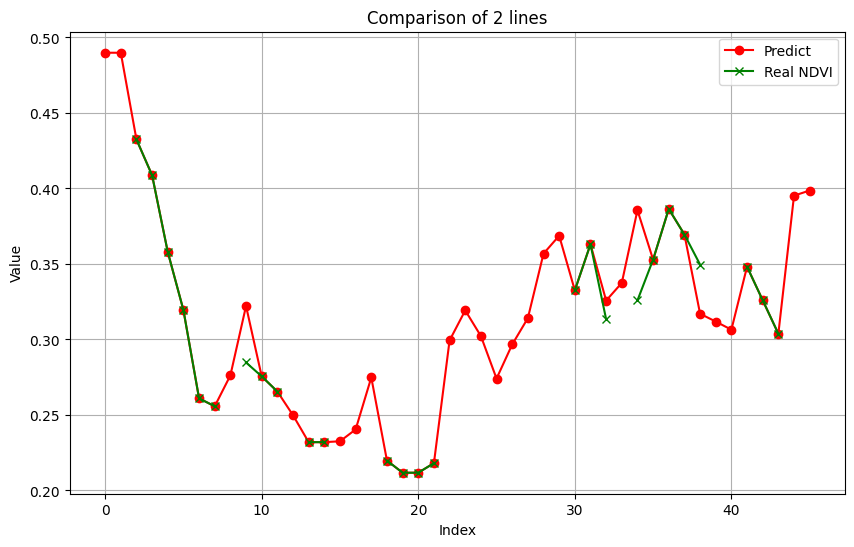

In [305]:
import matplotlib.pyplot as plt
import numpy as np

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(test[6000], label='Predict', color='r', marker='o')
plt.plot(ndvi_input[6000], label='Real NDVI', color='g', marker='x')

# Thiết lập tiêu đề và nhãn
plt.title("Comparison of 2 lines")
plt.xlabel("Index")
plt.ylabel("Value")

# Hiển thị chú thích và đồ thị
plt.legend()
plt.grid(True)
plt.show

# Inference 

Data input contains: 
- Values: VH, RVI, NDVI (have missing data)
- Prepare data
- Inference follow by (x,y)

In [ ]:
def Inference():
    print('=======')
    print('inference....')
    print('=======')
    
    

In [1]:
import numpy as np 

t = np.load('/mnt/storage/huyekgis/brios/BRIOS/models/test.npy')

In [3]:
t.shape

(160740, 46, 1)